In [1]:
from patchify import patchify
from transformers import SamModel, SamProcessor, SamConfig
import torch
from datasets import Dataset
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import random
import time

from utils import *

c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
c:\Users\firdavs\Documents\ARCL\DINOv2_Sparse_Matching\.venv\lib\site-packages\mobile_sam\modeling\tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expect

In [2]:
paths = {
    'train': {'images':   r"data/sam_finetuning/train/images/",
              'masks':    r"data/sam_finetuning/train/masks/",
              'bboxes':   r"data/sam_finetuning/train/bboxes/"},
    'val':   {'images':   r"data/sam_finetuning/val/images/",
              'masks':    r"data/sam_finetuning/val/masks/",
              'bboxes':   r"data/sam_finetuning/val/bboxes/"},
    'test':  {'images':   r"data/sam_finetuning/test/images/",
              'masks':    r"data/sam_finetuning/test/masks/",
              'bboxes':   r"data/sam_finetuning/test/bboxes/"}
}

train_images = get_images(paths['train']['images'])
val_images   = get_images(paths['val']['images'])
test_images  = get_images(paths['test']['images'])

train_masks  = get_images(paths['train']['masks'])
val_masks    = get_images(paths['val']['masks'])
test_masks   = get_images(paths['test']['masks'])

train_bboxes = get_bboxes(paths['train']['bboxes'])
val_bboxes   = get_bboxes(paths['val']['bboxes'])
test_bboxes  = get_bboxes(paths['test']['bboxes'])

n_train = len(train_images)
n_val   = len(val_images)
n_test  = len(test_images)

print(f'num train_images: {n_train}')
print(f'num val_images: {n_val}')
print(f'num test_images: {n_test}')

original_dims = (512, 641)

num train_images: 411
num val_images: 102
num test_images: 101


In [3]:
nosat_images = get_images(r'data/nosat/')
max_test_key = max(test_images.keys())
for key in nosat_images:
    test_images[max_test_key + key] = nosat_images[key]
    test_masks[max_test_key + key] = np.zeros(original_dims)
    test_bboxes[max_test_key + key] = None
    
print(f'num test_images: {len(test_images)}')

num test_images: 126


In [4]:
# for idx, image in train_images.items():
#     if idx in train_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/train/images/' + str(idx) + '.png')
        
#         seg_model_size = train_correct_masked_images[idx]
        
#         masks = all_train_masks[seg_model_size][idx]
#         bbox = train_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/train/masks/' + str(idx) + '.png')
        
#         bbox = train_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/train/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [5]:
# for idx, image in val_images.items():
#     if idx in val_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/val/images/' + str(idx) + '.png')
        
#         seg_model_size = val_correct_masked_images[idx]
        
#         masks = all_val_masks[seg_model_size][idx]
#         bbox = val_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/val/masks/' + str(idx) + '.png')
        
#         bbox = val_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/val/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [6]:
# for idx, image in test_images.items():
#     if idx in test_correct_masked_images:
#         img = Image.fromarray(image)
#         img.save('data/sam_finetuning/test/images/' + str(idx) + '.png')
        
#         seg_model_size = test_correct_masked_images[idx]
        
#         masks = all_test_masks[seg_model_size][idx]
#         bbox = test_bboxes[idx]
#         possible_masks = find_mask_in_bbox(masks, bbox)
        
#         mask = np.zeros(original_dims)
#         for mask_, _ in possible_masks:
#             mask = np.logical_or(mask, mask_['segmentation'])
#         mask = np.array(mask, dtype=np.uint8) * 255
        
#         mask = Image.fromarray(mask)
#         mask.save('data/sam_finetuning/test/masks/' + str(idx) + '.png')
        
#         bbox = test_bboxes[idx]
#         (x, y), w, h = bbox
#         with open('data/sam_finetuning/test/bboxes/' + str(idx) + '.txt', 'w') as f:
#             f.write(f'{x} {y} {w} {h}')
#         f.close()

In [7]:
def resize_image(img_arr: np.ndarray, w: int, h: int) -> np.ndarray:
    img = Image.fromarray(img_arr)
    img = img.resize((w, h))
    return np.array(img)

def prepare_datasets(patch_size: int, image_dims: tuple[int, int]) -> tuple[Dataset, Dataset]:
    step = patch_size

    x_factor = original_dims[1] / image_dims[1]
    y_factor = original_dims[0] / image_dims[0]

    # Combine train and val images as train
    train_img_patches = []
    train_mask_patches = []
    
    val_img_patches = []
    val_mask_patches = []

    test_img_patches = []
    test_mask_patches = []

    # Process train images
    i = 0
    for key in tqdm(train_images):
        # Load and resize image
        img = train_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                train_img_patches.append(single_patch_img)
        
        # Load and resize mask
        mask = train_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                train_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process val images
    i = 0
    for key in tqdm(val_images):
        # Load and resize image
        img = val_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                val_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = val_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                val_mask_patches.append(single_patch_mask)
        
        i += 1

    # Process test images
    i = 0
    for key in tqdm(test_images):
        # Load and resize image
        img = test_images[key]
        img = resize_image(img, image_dims[0], image_dims[1])

        # Patchify image
        patches_img = patchify(img, (patch_size, patch_size, 3), step=step)
        for j in range(patches_img.shape[0]):
            for k in range(patches_img.shape[1]):
                single_patch_img = patches_img[j,k,:,:][0]
                test_img_patches.append(single_patch_img)

        # Load and resize mask
        mask = test_masks[key][:, :, 0] / 255
        mask = resize_image(mask, image_dims[0], image_dims[1])

        # Patchify mask
        patches_mask = patchify(mask, (patch_size, patch_size), step=step)
        for j in range(patches_mask.shape[0]):
            for k in range(patches_mask.shape[1]):
                single_patch_mask = patches_mask[j,k,:,:]
                test_mask_patches.append(single_patch_mask)
        
        i += 1 
        
    X_train = np.array(train_img_patches)
    Y_train = np.array(train_mask_patches)
    
    X_val = np.array(val_img_patches)
    Y_val = np.array(val_mask_patches)

    X_test = np.array(test_img_patches)
    Y_test = np.array(test_mask_patches)

    valid_indices = [i for i, mask in enumerate(Y_train) if mask.max() != 0]
    X_train = X_train[valid_indices]
    Y_train = Y_train[valid_indices]
    print("X_train shape:", X_train.shape)
    print("Y_train shape:", Y_train.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_val) if mask.max() != 0]
    X_val = X_val[valid_indices]
    Y_val = Y_val[valid_indices]
    print("X_val shape:", X_val.shape)
    print("Y_val shape:", Y_val.shape)
    
    valid_indices = [i for i, mask in enumerate(Y_test) if mask.max() != 0]
    X_test = X_test[valid_indices]
    Y_test = Y_test[valid_indices]
    print("X_test shape:", X_test.shape)
    print("Y_test shape:", Y_test.shape)
    
    train_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_train],
        "mask":  [Image.fromarray(mask) for mask in Y_train],
    }
    val_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_val],
        "mask":  [Image.fromarray(mask) for mask in Y_val],
    }
    test_dict = {
        "image": [Image.fromarray(img.astype('uint8')) for img in X_test],
        "mask":  [Image.fromarray(mask) for mask in Y_test],
    }

    train_dataset = Dataset.from_dict(train_dict)
    val_dataset  = Dataset.from_dict(val_dict)
    test_dataset  = Dataset.from_dict(test_dict)
    
    return train_dataset, val_dataset, test_dataset

In [8]:
# Get bounding boxes from mask. (FROM ONLINE SOURCE)
def get_bounding_box(ground_truth_map: np.ndarray) -> list[int]:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [9]:
patch_size = 256
# image_size = 512

# train_dataset, val_dataset, test_dataset = prepare_datasets(patch_size, (image_size, image_size))

In [10]:
# train_dataset, val_dataset, test_dataset

In [11]:
# img_num = random.randint(0, n_train-1)
# example_image = train_dataset[img_num]["image"]
# example_mask = np.array(train_dataset[img_num]["mask"]) * 255
# # example_bbox = train_dataset[img_num]["bbox"]

# bbox = get_bounding_box(np.array(example_mask))

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Plot the iamge on left
# axes[0].imshow(np.array(example_image), cmap='gray')
# axes[0].set_title("Image")

# # Plot the mask on right
# axes[1].imshow(example_mask, cmap='gray')
# axes[1].set_title("Mask")

# # Hide axis ticks and labels
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
#     rect_pred = Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
#     # rect_true = Rectangle((example_bbox[0], example_bbox[1]), example_bbox[2], example_bbox[3], linewidth=2, edgecolor='g', facecolor='none')
    
#     ax.add_patch(rect_pred)
#     # ax.add_patch(rect_true)

# plt.show()

In [12]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    """
    Used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        
        ground_truth_mask = np.array(item["mask"])

        # Get bounding box prompt
        # prompt = get_bounding_box(ground_truth_mask)
        prompt = [0, 0, 256, 256]

        # Prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # Remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # Add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [13]:
def load_model_and_processor(model_path) -> tuple[SamModel, SamProcessor]:
    # Load the model configuration
    model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
    processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
    print(model_path)
    # Create an instance of the model architecture with the loaded configuration
    model = SamModel(config=model_config)
    # Update the model by loading the weights from saved file.
    model.load_state_dict(torch.load(model_path))
    
    return model, processor

def get_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device

In [95]:
def prepare_image(image: np.ndarray, dims: tuple[int, int], verbose=True) -> torch.Tensor:
    start_time = time.time()
    
    image = resize_image(image, dims[0], dims[1])
    patches = patchify(np.array(image), (patch_size, patch_size, 3), step=256)
    patches = np.squeeze(patches)
    
    end_time = time.time()
    
    if verbose:
        print(f"Time taken to prepare image: {end_time - start_time:.2f} seconds")
    
    return patches

def predict(model: SamModel, processor: SamProcessor, device: torch.device, image: torch.Tensor, dims: tuple[int, int], thresh: float = 0.5, verbose=True) -> (torch.Tensor, torch.Tensor):
    start_time = time.time()
    model.eval()
    
    patches = prepare_image(image, dims, verbose=verbose)
    
    prob = None
    
    for row_patches in patches:
        row_prob = None
        for patch in row_patches:
            inputs = processor(patch, return_tensors="pt")
            inputs = {k:v.to(device) for k,v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs, multimask_output=False)
            single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
            single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
            single_patch_prob = single_patch_prob / np.sum(single_patch_prob)
            
            if row_prob is None:
                row_prob = single_patch_prob
            else:
                row_prob = np.concatenate((row_prob, single_patch_prob), axis=1)
                
        if prob is None:
            prob = row_prob
        else:
            prob = np.concatenate((prob, row_prob), axis=0)
    
    # # Find top 4 patches with highest stddev
    # highest_stddev = []
    # for i in range(int(prob.shape[0] / patch_size)):
    #     for j in range(int(prob.shape[1] / patch_size)):
    #         patch = prob[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    #         stddev = np.std(patch)
    #         highest_stddev.append((i, j, stddev))
    # highest_stddev = sorted(highest_stddev, key=lambda x: x[2], reverse=True)[:4]
    # print([(i, j) for i, j, _ in highest_stddev])
    
    # # Zero patches not in highest_stddev
    # for i in range(int(prob.shape[0] / patch_size)):
    #     for j in range(int(prob.shape[1] / patch_size)):
    #         if (i, j) not in [(i, j) for i, j, _ in highest_stddev]:
    #             prob[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = 0
    
    pred = (prob > prob.max() * thresh).astype(np.uint8)
    
    pred = resize_image(pred, original_dims[1], original_dims[0])
    prob = resize_image(prob, original_dims[1], original_dims[0])
    
    end_time = time.time()
    if verbose:
        print(f"Time taken to predict: {end_time - start_time:.2f} seconds")
    
    return pred, prob

def plot_prediction(image: np.ndarray, prediction: np.ndarray, probability: np.ndarray, idx: int, bbox: tuple = None) -> None:
    if bbox:
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    else:
        fix, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the first image on the left
    axes[0].imshow(np.array(image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title(idx)

    # Plot the second image on the right
    axes[1].imshow(probability)  # Assuming the second image is grayscale
    axes[1].set_title("Probability Map")

    # Plot the second image on the right
    axes[2].imshow(prediction, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Prediction")
    
    if bbox:
        axes[3].imshow(prediction, cmap='gray') 
        axes[3].set_title("Prediction with bbox")
        
        (x, y), w, h = bbox
        r = Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3].add_patch(r)

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

In [15]:
device = get_device()

models = {}
processors = {}

model_paths = {
    512: "sam_checkpoints_finetuned/512.pth",
    1024: "sam_checkpoints_finetuned/1024.pth",
    2048: "sam_checkpoints_finetuned/2048.pth"

}

for size in [512, 1024, 2048]:
    model, processor = load_model_and_processor(model_paths[size])
    model.to(device)
    models[size] = model
    processors[size] = processor
    
torch.cuda.empty_cache()

sam_checkpoints_finetuned/512.pth
sam_checkpoints_finetuned/1024.pth
sam_checkpoints_finetuned/2048.pth


Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.74 seconds


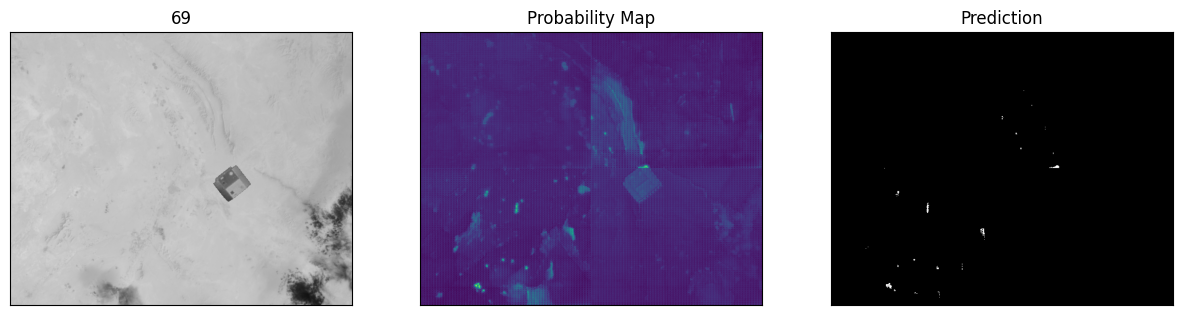

In [96]:
idx = random.choice(list(test_images.keys()))
idx = 69
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.32 seconds


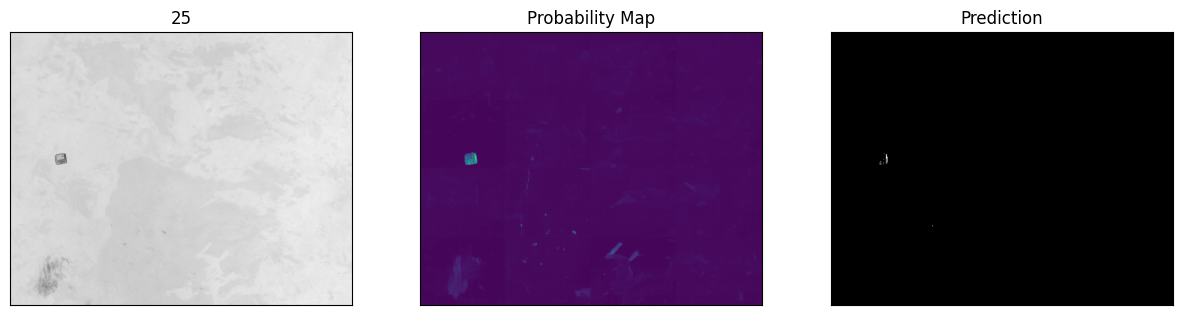

In [97]:
idx = 25
test_image = test_images[idx]

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.03 seconds
Time taken to predict: 8.83 seconds


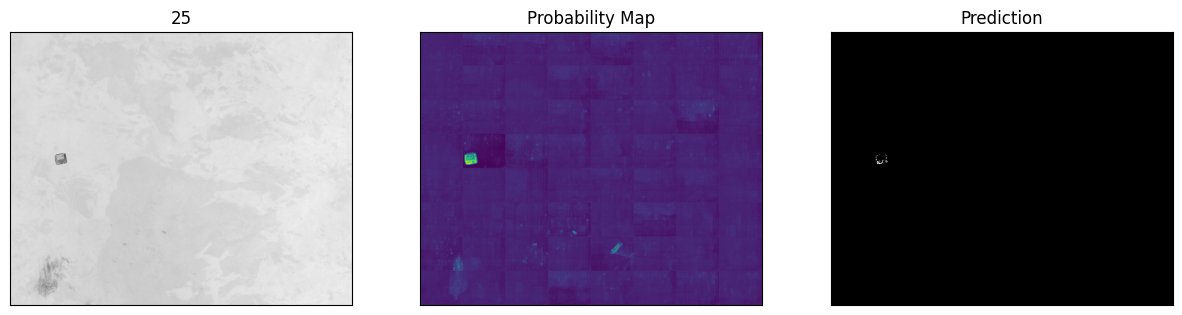

In [98]:
idx = 25
test_image = test_images[idx]

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.53 seconds


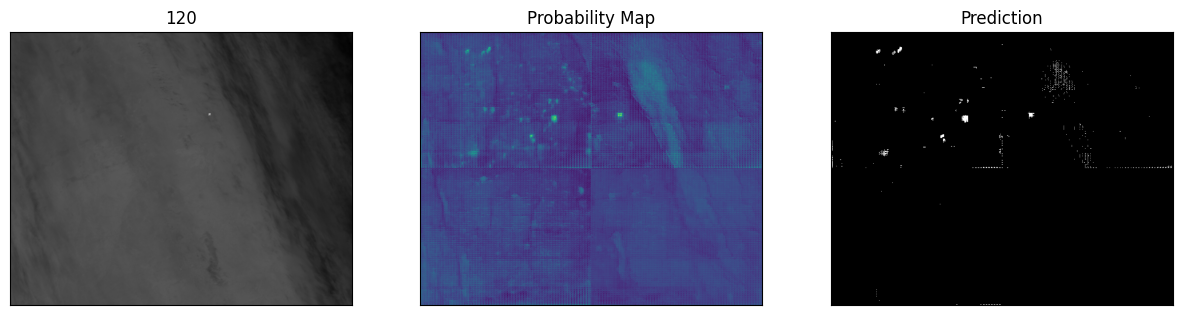

In [99]:
# idx = random.randint(1, len(test_images))
idx = 120
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.17 seconds


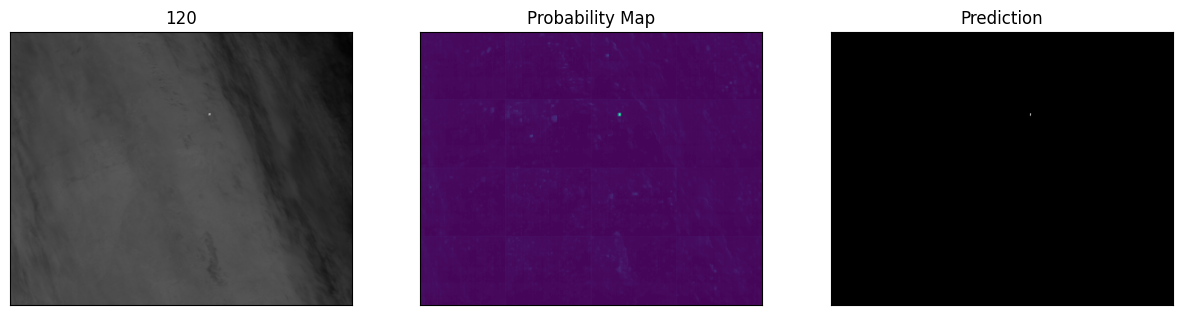

In [100]:
idx = 120
test_image = test_images[idx]

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.04 seconds
Time taken to predict: 8.65 seconds


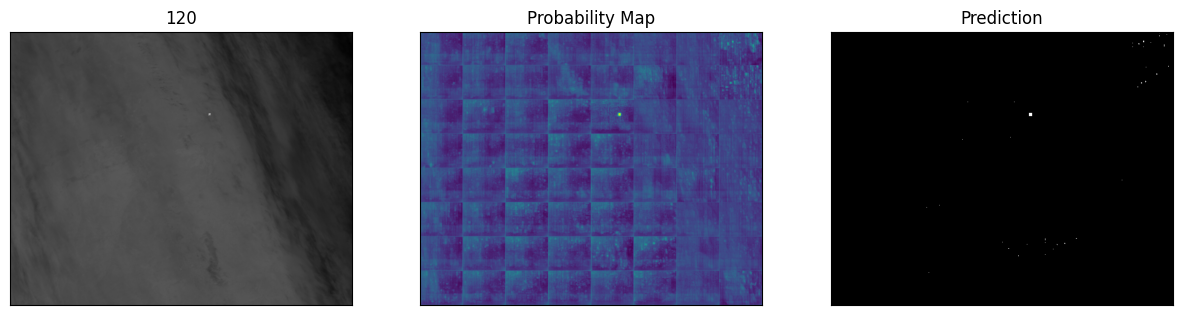

In [101]:
idx = 120
test_image = test_images[idx]

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

Time taken to prepare image: 0.00 seconds
Time taken to predict: 0.76 seconds


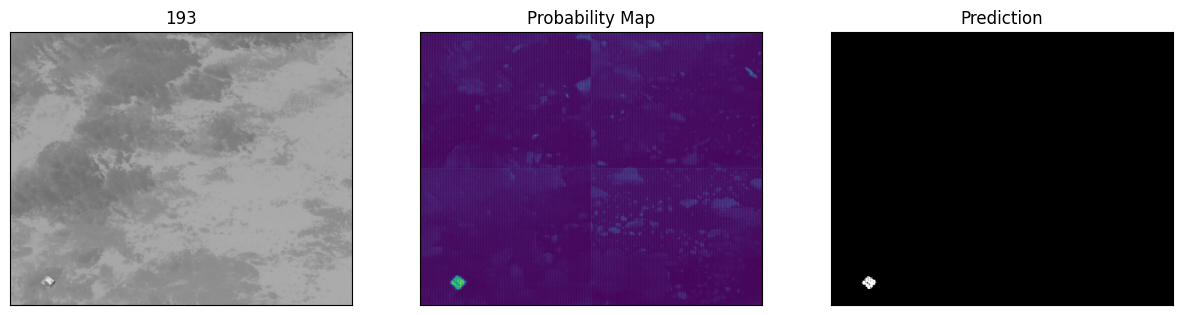

Time taken to prepare image: 0.01 seconds
Time taken to predict: 2.17 seconds


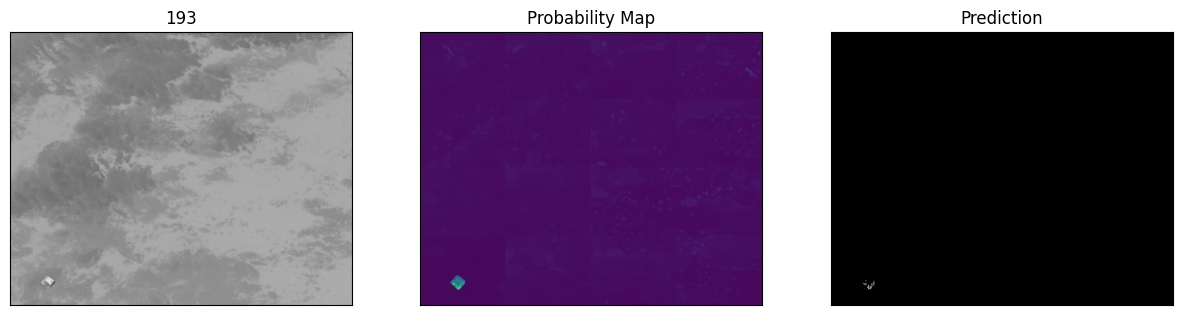

Time taken to prepare image: 0.03 seconds
Time taken to predict: 8.54 seconds


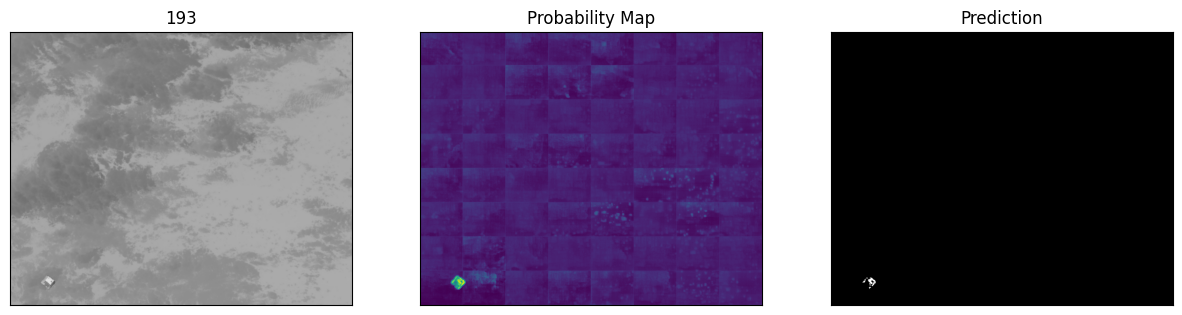

In [104]:
# idx = random.choice(list(test_images.keys()))
idx = 193
test_image = test_images[idx]

image_size = 512

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

image_size = 1024

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

image_size = 2048

pred, prob = predict(models[image_size], processors[image_size], device, test_image, (image_size, image_size), thresh=0.5)
plot_prediction(test_image, pred, prob, idx)

In [23]:
# from torch.utils.data import DataLoader

# test_sam_dataset = SAMDataset(dataset=test_dataset, processor=processor)
# test_dataloader = DataLoader(test_sam_dataset, batch_size=2, shuffle=True, drop_last=False)

In [24]:
# from torch.optim import Adam
# import monai
# from statistics import mean

# model = models[512]
# optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

# model.eval()
# losses = []
# for batch in tqdm(test_dataloader):
#     # forward pass
#     outputs = model(pixel_values=batch["pixel_values"].to(device),
#                     input_boxes=batch["input_boxes"].to(device),
#                     multimask_output=False)

#     # compute loss
#     predicted_masks = outputs.pred_masks.squeeze(1)
#     ground_truth_masks = batch["ground_truth_mask"].float().to(device)
#     loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

#     loss.backward()
#     losses.append(loss.item())

In [25]:
# print(f'Mean DiceCELoss: {mean(losses)}')

In [107]:
def mask_within_bbox(mask: np.ndarray, bbox: tuple[tuple[int, int], int, int]) -> bool:
    tot_area = np.sum(mask)
    
    (x, y), w, h = bbox
    
    area_in_bbox = 0
    for dw in range(w):
        for dh in range(h):
            if mask[y + dh, x + dw] == 1:
                area_in_bbox += 1

    return area_in_bbox / tot_area > 0.5

def joint_intersection(mask1, mask2, thresh) -> bool:
    intersection = np.logical_and(mask1, mask2)
    return np.sum(intersection) > thresh

In [109]:
def calc_accuracy(model: SamModel, processor: SamProcessor, images: dict[int, np.ndarray], bboxes: dict[int, tuple], image_size: int, thresh: float = 0.5) -> float:
    device = get_device()
    model.to(device)

    x_factor = original_dims[1] / image_size
    y_factor = original_dims[0] / image_size
    
    accuracies = []
    for idx, image in tqdm(images.items()):
        mask_pred, _ = predict(model, processor, device, image, (image_size, image_size), thresh, verbose=False)
        bbox = bboxes[idx]
        
        if bbox is None:
            if mask_pred.max() == 0:
                accuracies.append(1)
            else:
                accuracies.append(0)
            continue
        
        # (x, y), w, h = bbox
        # bbox = ((round(x/x_factor), round(y/y_factor)), round(w/x_factor), round(h/y_factor))
        
        mask_true = np.array(test_masks[idx][:, :, 0] / 255, dtype=np.uint8)
        # if mask_within_bbox(mask_pred, bbox):
        if joint_intersection(mask_pred, mask_true, 0.5):
            accuracies.append(1)
        else:
            accuracies.append(0)

    return np.mean(accuracies)

In [110]:
test_acc_512 = calc_accuracy(models[512], processors[512], test_images, test_bboxes, 512, thresh=0.65)
print(test_acc_512)

100%|██████████| 126/126 [01:08<00:00,  1.85it/s]

0.6190476190476191


In [112]:
test_acc_1024 = calc_accuracy(models[1024], processors[1024], test_images, test_bboxes, 1024, thresh=0.65)
print(test_acc_1024)

100%|██████████| 126/126 [04:27<00:00,  2.12s/it]

0.5396825396825397


In [113]:
test_acc_2048 = calc_accuracy(models[2048], processors[2048], test_images, test_bboxes, 2048, thresh=0.65)
print(test_acc_2048)

100%|██████████| 126/126 [19:23<00:00,  9.23s/it]

0.3968253968253968


In [30]:
def test_threshs(threshs: list[float], model: SamModel, processor: SamProcessor, images: dict[int, np.ndarray], bboxes: dict[int, tuple], image_size: int) -> dict[float, float]:
    accs = {}
    for thresh in threshs:
        print(f"Testing threshold: {thresh}")
        acc = calc_accuracy(model, processor, images, bboxes, image_size, thresh)
        print(f"Accuracy: {acc:.4f}\n")
        accs[thresh] = acc
    return accs

In [31]:
thresh_accs_512 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[512], processors[512], val_images, val_bboxes, 512)

import pickle
pickle.dump(thresh_accs_512, open("thresh_accs_512_2.pkl", "wb"))

Testing threshold: 0.3


100%|██████████| 102/102 [00:54<00:00,  1.89it/s]


Accuracy: 0.1961

Testing threshold: 0.35


 36%|███▋      | 37/102 [00:19<00:34,  1.86it/s]


KeyboardInterrupt: 

In [ ]:
thresh_accs_1024 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[1024], processors[1024], val_images, val_bboxes, 1024)

import pickle
pickle.dump(thresh_accs_1024, open("thresh_accs_1024_2.pkl", "wb"))

Testing threshold: 0.3


100%|██████████| 102/102 [04:14<00:00,  2.49s/it]


Accuracy: 0.5196

Testing threshold: 0.35


100%|██████████| 102/102 [04:05<00:00,  2.41s/it]


Accuracy: 0.5588

Testing threshold: 0.4


100%|██████████| 102/102 [04:08<00:00,  2.44s/it]


Accuracy: 0.5686

Testing threshold: 0.45


100%|██████████| 102/102 [04:12<00:00,  2.48s/it]


Accuracy: 0.5980

Testing threshold: 0.5


100%|██████████| 102/102 [04:17<00:00,  2.53s/it]


Accuracy: 0.6176

Testing threshold: 0.55


100%|██████████| 102/102 [04:02<00:00,  2.38s/it]


Accuracy: 0.6275

Testing threshold: 0.6


100%|██████████| 102/102 [04:10<00:00,  2.46s/it]


Accuracy: 0.6373

Testing threshold: 0.65


100%|██████████| 102/102 [04:09<00:00,  2.45s/it]


Accuracy: 0.6275

Testing threshold: 0.7


100%|██████████| 102/102 [04:19<00:00,  2.54s/it]

Accuracy: 0.6275



In [ ]:
thresh_accs_2048 = test_threshs([0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7], models[2048], processors[2048], val_images, val_bboxes, 2048)

import pickle
pickle.dump(thresh_accs_2048, open("thresh_accs_2048_2.pkl", "wb"))

Testing threshold: 0.3


100%|██████████| 102/102 [16:39<00:00,  9.80s/it]


Accuracy: 0.1863

Testing threshold: 0.35


100%|██████████| 102/102 [16:39<00:00,  9.80s/it]


Accuracy: 0.2549

Testing threshold: 0.4


100%|██████████| 102/102 [16:39<00:00,  9.80s/it]


Accuracy: 0.3137

Testing threshold: 0.45


100%|██████████| 102/102 [16:39<00:00,  9.80s/it]


Accuracy: 0.3333

Testing threshold: 0.5


100%|██████████| 102/102 [16:41<00:00,  9.81s/it]


Accuracy: 0.3725

Testing threshold: 0.55


100%|██████████| 102/102 [16:40<00:00,  9.81s/it]


Accuracy: 0.3824

Testing threshold: 0.6


100%|██████████| 102/102 [16:41<00:00,  9.82s/it]


Accuracy: 0.3824

Testing threshold: 0.65


100%|██████████| 102/102 [16:40<00:00,  9.81s/it]


Accuracy: 0.3824

Testing threshold: 0.7


100%|██████████| 102/102 [14:49<00:00,  8.72s/it]

Accuracy: 0.4020



Time taken to prepare image: 0.01 seconds


Time taken to predict: 2.19 seconds
True


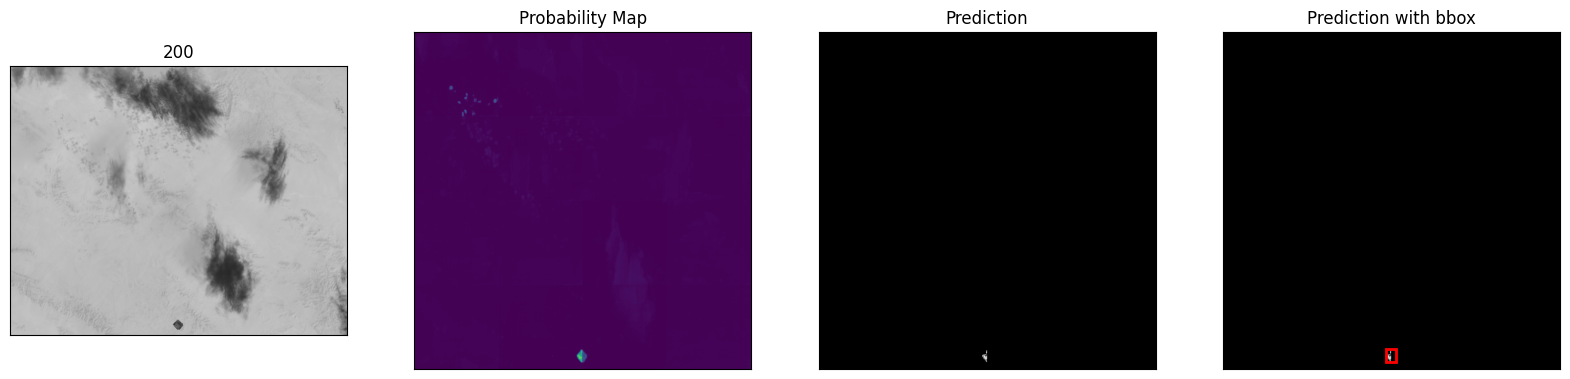

: 

In [ ]:
image_size = 512
model = models[image_size]
processor = processors[image_size]

device = get_device()
model.to(device)

x_factor = original_dims[1] / image_size
y_factor = original_dims[0] / image_size

idx = random.choice(list(test_images.keys()))
image = test_images[idx]

mask_pred, mask_prob = predict(model, processor, device, image, (image_size, image_size), 0.65)
bbox = test_bboxes[idx]

(x, y), w, h = bbox
bbox = ((round(x/x_factor), round(y/y_factor)), round(w/x_factor), round(h/y_factor))

if mask_within_bbox(mask_pred, bbox):
    print(True)
else:
    print(False)

plot_prediction(image, mask_pred, mask_prob, idx, bbox)